In [1]:
import numpy as np
from jax import jit
from jaxdf import FourierSeries
from matplotlib import pyplot as plt

from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import *
from jwave.signal_processing import analytic_signal, apply_ramp, gaussian_window, smooth
from jwave.utils import show_field, show_positive_field

from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d

In [2]:
Nx = 256
dx = 0.1e-3 * 128 / Nx
domain = Domain((Nx, Nx), (dx, dx))
N = domain.N

c0 = 1540
rho0 = 1000

dt = 1.5e-8
t_end = 1.4e-5

x_sensors = np.linspace(25, Nx - 25, 256)
y_sensor_options = np.linspace(20, 40, 10) * Nx / 128

y_p0 = 40 * Nx // 128
p0 = np.zeros(N)
p0[y_p0, 25 : Nx - 25] = 1
p0 = 1.0 * jnp.expand_dims(p0, -1)
p0 = FourierSeries(p0, domain)

time_axis = TimeAxis(dt=dt, t_end=t_end)

1. Make a homogeneous model to act as a baseline.

In [3]:
density = np.ones(domain.N) * rho0
sound_speed = np.ones(domain.N) * c0

density = FourierSeries(jnp.expand_dims(density, -1), domain)
sound_speed = FourierSeries(jnp.expand_dims(sound_speed, -1), domain)

medium = Medium(domain=domain, sound_speed=sound_speed, density=density, pml_size=20)

bli_sensors = [
    BLISensors(positions=(np.ones_like(x_sensors) * y, x_sensors), n=domain.N)
    for y in y_sensor_options
]

sensors = lambda *args: [bli(*args) for bli in bli_sensors]


@jit
def compiled_simulator():
    return simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensors)


pressure = compiled_simulator()
pressure = np.squeeze(np.array(pressure))
np.save("PressureNull", pressure)

2. Make the US scattering version. Set up the model:

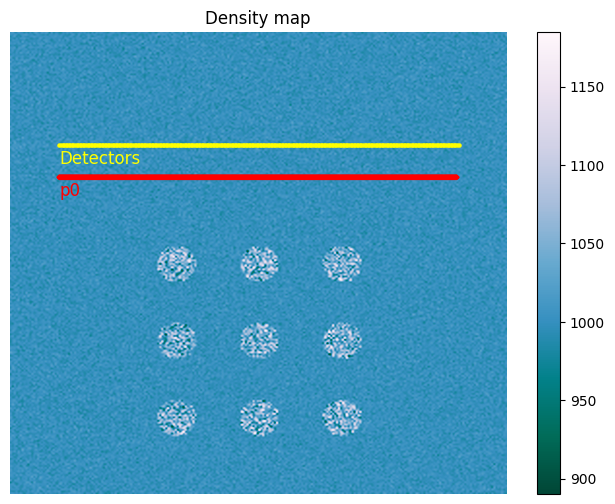

In [12]:
density = np.ones(domain.N) * rho0
sound_speed = np.ones(domain.N) * c0

noise = np.random.normal(size=domain.N, loc=1, scale=0.008)
density *= noise
sound_speed *= noise

circle_centres = [(x, y) for x in [2 / 3, 1 / 2, 5 / 6] for y in [1 / 2, 2 / 3, 1 / 3]]
radius = 5 / 128

masks = []
random_weighting = np.random.normal(size=domain.N, loc=25 + c0, scale=75)
for x, y in circle_centres:
    mask = circ_mask(domain.N, radius * Nx, (x * Nx, y * Nx)) == 1
    sound_speed[mask] = random_weighting[mask]
    density[mask] = random_weighting[mask] / 1.5

sound_speed = FourierSeries(jnp.expand_dims(sound_speed, -1), domain)
density = FourierSeries(jnp.expand_dims(density, -1), domain)

show_positive_field(density)
plt.contour(np.squeeze(p0.on_grid), colors="red")
plt.text(25, y_p0 + 10, "p0", color="red", fontsize="large")

f = bli_sensors[-5].positions
plt.scatter(f[1], f[0], color="yellow", s=5)
plt.text(f[1][0], f[0][0] + 10, "Detectors", color="yellow", fontsize="large")

plt.title("Density map")
plt.savefig("DensityMap")
plt.show()

In [5]:
medium = Medium(domain=domain, sound_speed=sound_speed, density=density, pml_size=20)

# Add a vessel to p0 to see what happens if you have a second circular absorber in the PA image.
radius = 5 / 128
mask_vessel = (
    circ_mask(domain.N, radius / 2 * Nx, ((1 / 3 + 1 / 12) * Nx, 1 / 2 * Nx)) == 1
)

p0 = np.zeros(N)
p0[y_p0, 25 : Nx - 25] = 1
# p0[mask_vessel] = 1

p0 = 1.0 * jnp.expand_dims(p0, -1)
p0 = FourierSeries(p0, domain)

In [13]:
@jit
def compiled_simulator():
    return simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensors)


pressure = compiled_simulator()

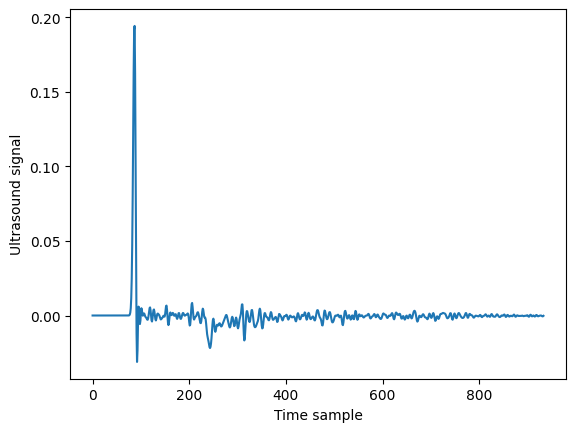

In [21]:
plt.plot(pressure[0][:, :, 0][:, 128])
plt.xlabel("Time sample")
plt.ylabel("Ultrasound signal")
plt.savefig("simtimeseries")
plt.show()

In [7]:
pressure = np.squeeze(np.array(pressure))
pressure -= np.load("PressureNull.npy")

In [8]:
np.vstack([pressure[0], np.zeros([10, 256])]).shape

(944, 256)

3. Reconstruct the scatterer distribution.

In [9]:
def run_reconstruction(pressure_calc, delta_source_detector=0):
    # 1. Filter
    # zeropad? Seems to make it worse??
    pressure_calc = np.vstack(
        [pressure_calc, np.zeros((pressure_calc.shape[1] // 2, pressure_calc.shape[1]))]
    )
    b, a = butter(5, [5e3, 30e6], btype="bandpass", fs=1 / dt)
    fp = np.array(
        filtfilt(b, a, pressure_calc, axis=0, padtype="even", padlen=100, method="pad")
    )

    # 2. Fourier transform and interpolate
    p_fft = np.fft.fftshift(np.fft.fft2(fp))

    omegas = np.fft.fftshift(np.fft.fftfreq(pressure_calc.shape[0], d=dt))[:, None]
    kx_s = np.fft.fftshift(
        np.fft.fftfreq(
            pressure_calc.shape[1], d=domain.dx[0] * (x_sensors[1] - x_sensors[0])
        )
    )[None, :]
    with np.errstate(all="ignore"):
        kz_s = np.sqrt((omegas / c0) ** 2 - kx_s**2)
    kz_primes = omegas / c0 + kz_s
    kz_primes[omegas[:, 0] < 0] = np.nan

    p_fft *= np.exp(-1j * 2 * np.pi * kz_s * delta_source_detector)

    # plt.imshow(kz_primes, aspect="auto", origin="lower")
    # plt.show()

    kz_interp = np.linspace(kx_s.min(), kx_s.max(), kx_s.shape[1] * 2)
    ongrid = np.ones((kz_interp.shape[0], kx_s.shape[1]), dtype=np.complex128)

    for i in range(kx_s.shape[1]):
        kz_prime = kz_primes[:, i]
        nonans = ~np.isnan(kz_prime)
        ongrid[:, i] = interp1d(
            kz_prime[nonans],
            np.real(p_fft[:, i][nonans]),
            fill_value=0,
            bounds_error=False,
        )(kz_interp)
        ongrid[:, i] += (
            1j
            * interp1d(
                kz_prime[nonans],
                np.imag(p_fft[:, i][nonans]),
                fill_value=0,
                bounds_error=False,
            )(kz_interp)
            * np.sign(kz_interp)
        )
    image = np.fft.ifft2(ongrid)
    image = np.abs(hilbert(image.real, axis=0)[: image.shape[0] // 2])
    gain = np.exp(np.arange(image.shape[0]) / 25 * image.shape[0] / 512)
    image *= gain[:, None]
    return np.log10(1 + 3 * image) / np.log10(4)

In [10]:
extent_image = lambda i: (
    x_sensors.min(),
    x_sensors.max(),
    y_sensor_options[i] + x_sensors.max() - x_sensors.min(),
    y_sensor_options[i],
)

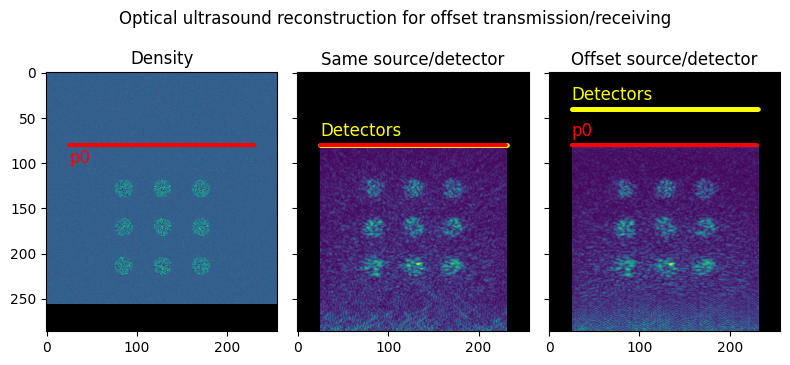

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

image = run_reconstruction(pressure[-1])

ax1.imshow(density.on_grid[:, :, 0])
ax2.imshow(image, extent=extent_image(-1))

source_detector_offset = dx * (y_sensor_options[0] - y_p0)
image = run_reconstruction(pressure[0], source_detector_offset)

ax3.imshow(image, extent=extent_image(-1))

ax1.contour(np.squeeze(p0.on_grid), colors="red")
ax1.text(25, y_p0 + 20, "p0", color="red", fontsize="large")
ax2.contour(np.squeeze(p0.on_grid), colors="red")
ax3.contour(np.squeeze(p0.on_grid), colors="red")
ax3.text(25, y_p0 - 10, "p0", color="red", fontsize="large")

f = bli_sensors[-1].positions
ax2.scatter(f[1], f[0], color="yellow", s=5)
ax2.text(f[1][0], f[0][0] - 10, "Detectors", color="yellow", fontsize="large")

f = bli_sensors[0].positions
ax3.scatter(f[1], f[0], color="yellow", s=5)
ax3.text(f[1][0], f[0][0] - 10, "Detectors", color="yellow", fontsize="large")

ax1.set_title("Density")
ax2.set_title("Same source/detector")
ax3.set_title("Offset source/detector")

plt.tight_layout()
ax1.set_facecolor("k")
ax2.set_facecolor("k")
ax3.set_facecolor("k")

fig.suptitle("Optical ultrasound reconstruction for offset transmission/receiving")
fig.savefig("usrec.png", dpi=300)
plt.show()